In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

plt.rcdefaults()
plt.rcParams.update({
    "text.usetex": True, # set to False if you don't have LaTeX installed
    "font.family": "serif",
})

In [2]:
df = pd.read_csv('temperature-intensity.csv')
T = df.iloc[:,1].to_numpy() # temperature
I = df.iloc[:,2].to_numpy() # intensity

# normalize data so that fitting is easier
T_norm = (T - np.mean(T))/np.std(T)
I_norm = (I - np.min(I))/np.std(I)

In [3]:
def sinc2_linear(x, A, x0, w, m, b):
    # sinc function + linear component
    # A = amplitude, x0 = center, w = width parameter, m = slope, b = offset
    arg = (x - x0) / w
    return A * np.sinc(arg)**2 + m * x + b

# np.sinc(x) = sin(pi*x)/(pi*x), FWHM of sinc ≈ 1.21 * w
# So w ≈ FWHM / 1.21 ≈ 1 / 1.21 ≈ 0.83
p0 = [3, 0.3, 0.83, 0, 0]

popt, pcov = curve_fit(sinc2_linear, T_norm, I_norm, p0=p0)

A, x0, w, m, b = popt
print(f"Amplitude: {A:.4f}")
print(f"Center:    {x0:.4f}")
print(f"Width:     {w:.4f}")
print(f"Slope:     {m:.4f}")
print(f"Offset:    {b:.4f}")

# Generate fitted curve
T_norm_fit = np.linspace(T_norm.min(), T_norm.max(), 500)
I_norm_fit = sinc2_linear(T_norm_fit, *popt)

Amplitude: 2.7923
Center:    0.2028
Width:     1.0109
Slope:     0.0267
Offset:    0.0394


Peak location: T=191.8784
Peak width: dT=6.1740


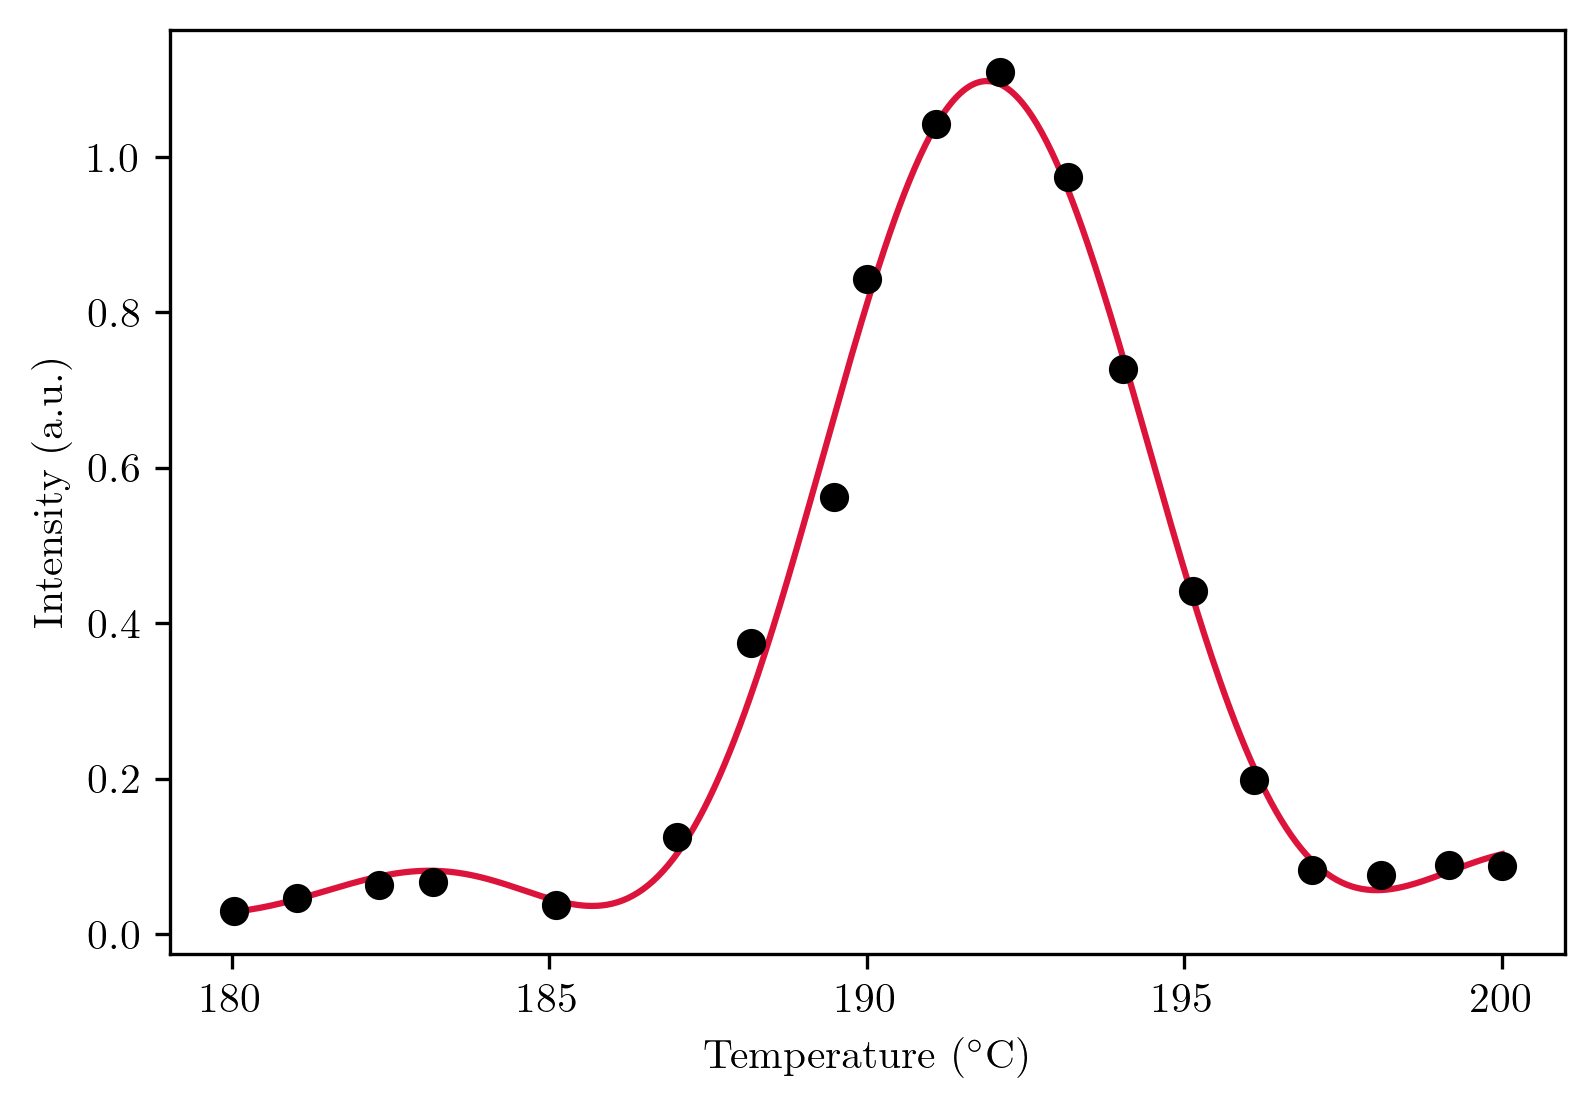

In [4]:
fig, ax = plt.subplots(figsize=(6,4), dpi=300)

#ax.set_yscale('log')

T_fit = np.std(T)*T_norm_fit + np.mean(T)
I_fit = np.std(I)*I_norm_fit + np.min(I)

T0 = np.std(T)*x0 + np.mean(T)
T_width = np.std(T)*w

ax.plot(T_fit, I_fit, color='crimson', zorder=1)
ax.scatter(T, I, color='k', zorder=2)

ax.set_xlabel('Temperature ($^{\\circ}$C)')
ax.set_xticks([180, 185, 190, 195, 200])
ax.set_ylabel('Intensity (a.u.)')

print(f'Peak location: T={T0:.4f}')
print(f'Peak width: dT={T_width:.4f}')

plt.show()

# Obtaining Confidence Intervals

In [24]:
from lmfit import Model, conf_interval, conf_interval2d

In [13]:
sinc_model = Model(sinc2_linear)

params = sinc_model.make_params(A=3, 
                            x0=0.3, 
                            w=0.83,
                            m=0,
                            b=0)


# we will use this array  of points to evaluate the fit
T_norm_fit = np.linspace(T_norm.min(), T_norm.max(), 500)

# get the fit result
I_norm_fit_result = sinc_model.fit(I_norm, params, x=T_norm)

#evaluate fit at fine sweep of x values
I_norm_fit_eval = I_norm_fit_result.eval(x=T_norm_fit)

# ci = conf_interval(I_norm_fit_result, I_norm_fit_result, sigmas=[1,2,3])

pred_ci = I_norm_fit_result.eval_uncertainty(x=T_norm_fit, sigma=3)

# print(ci)

# transform from normalized data to raw
T_fit = np.std(T)*T_norm_fit + np.mean(T)
I_fit_eval = np.std(I)*I_norm_fit_eval + np.min(I)

I_ci_up = np.std(I)*(I_norm_fit_eval + pred_ci) + np.min(I)
I_ci_down = np.std(I)*(I_norm_fit_eval - pred_ci) + np.min(I)

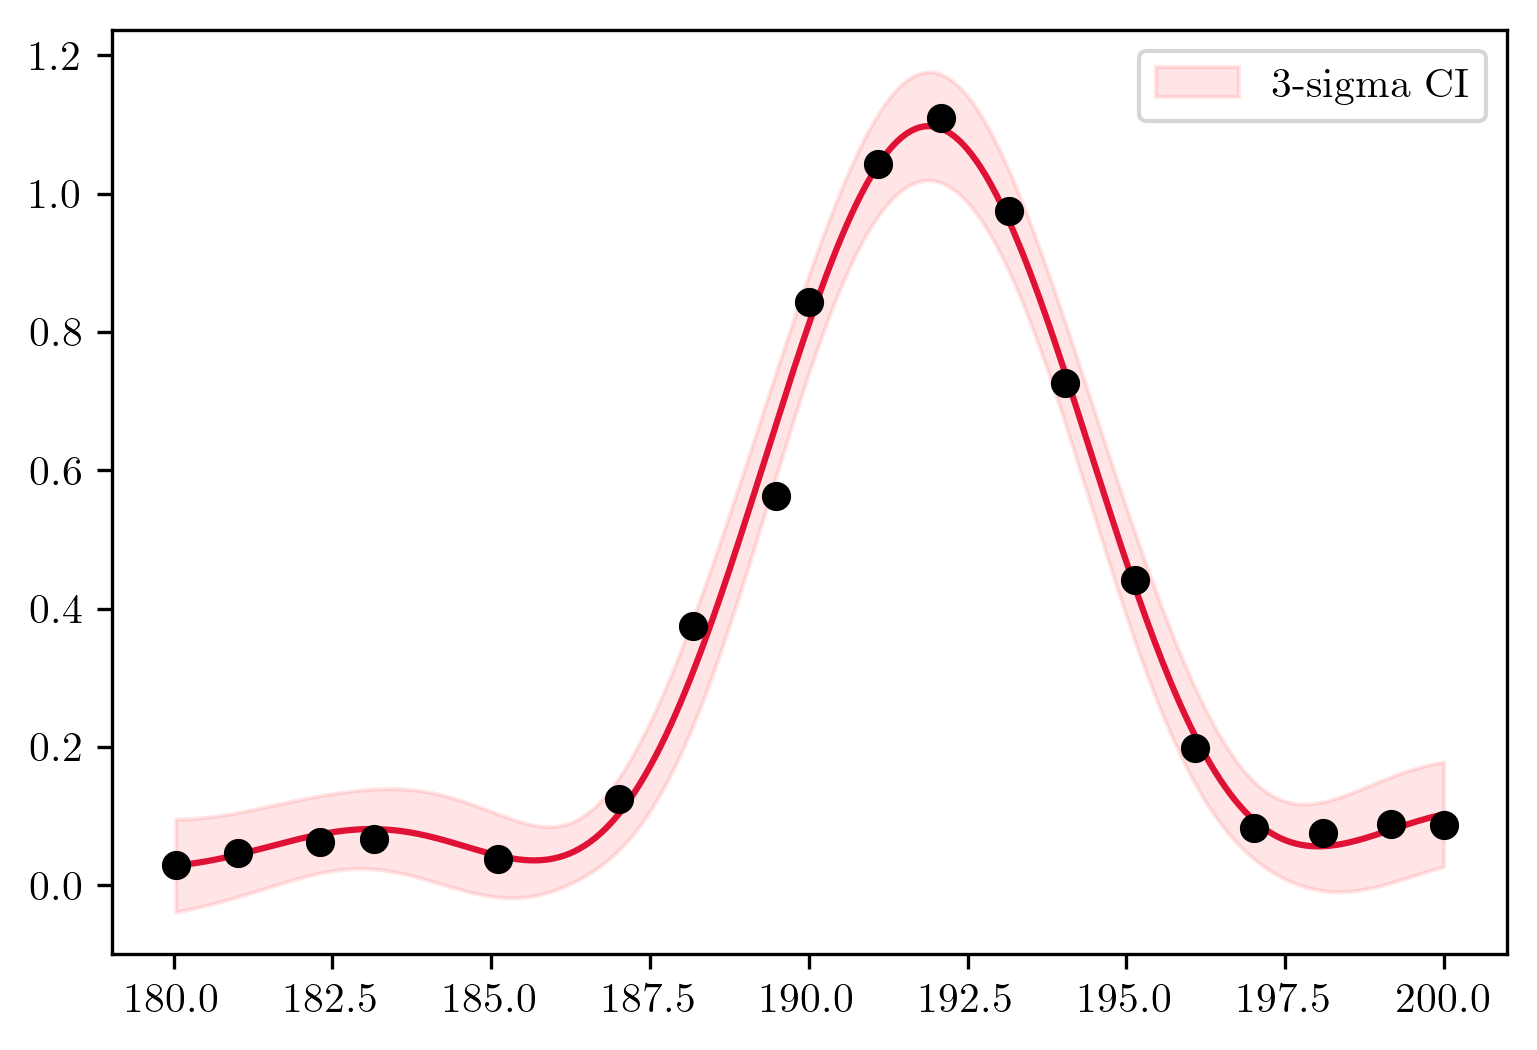

In [16]:
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
ax.plot(T_fit, I_fit_eval, color='crimson', zorder=1)
ax.scatter(T, I, color='k', zorder=2)
plt.fill_between(T_fit, I_ci_down, I_ci_up, 
                 color='red', alpha=0.1, label='3-sigma CI')
plt.legend()

Lets look at the confidence intervals of each of the parameters of the model

In [ ]:
params = sinc_model.make_params(A=3, 
                            x0=0.3, 
                            w=0.83,
                            m=0,
                            b=0)

In [22]:
import matplotlib.pyplot as plt

# Calculate the map for two specific parameters
cx, cy, grid = I_norm_fit_result.conf_interval(p_names=['A', 'x0'], sigmas=[0,1,2,3])



# Plotting the contours
plt.contourf(cx, cy, grid, levels=[0.68, 0.95, 0.99])
plt.xlabel('Amplitude')
plt.ylabel('Sigma')
plt.title('Confidence Contours')
plt.show()

ValueError: not enough values to unpack (expected 3, got 2)

This code is adapted from the example array of parameter confidence interval contour plots here: "https://lmfit.github.io/lmfit-py/confidence.html#confidence-chapter"

# NEXT TASK: NORMALIZE THE CI INFO 

Generating chi-square map for ('A', 'x0')
[(np.float64(0.9973002039367398), np.float64(2.553479177725097)), (np.float64(0.9544997361036416), np.float64(2.647906808581488)), (np.float64(0.6826894921370859), np.float64(2.724013875141236)), (0.0, 2.7922953713777465), (np.float64(0.6826894921370859), np.float64(2.8607168964971974)), (np.float64(0.9544997361036416), np.float64(2.9373133354592547)), (np.float64(0.9973002039367398), np.float64(3.032841362574521))]
Generating chi-square map for ('x0', 'w')
[(np.float64(0.9973002039367398), np.float64(0.16867852703310943)), (np.float64(0.9544997361036416), np.float64(0.18231725589994496)), (np.float64(0.6826894921370859), np.float64(0.1931553537983008)), (0.0, 0.20278120390073032), (np.float64(0.6826894921370859), np.float64(0.212349504007235)), (np.float64(0.9544997361036416), np.float64(0.2229877892969732)), (np.float64(0.9973002039367398), np.float64(0.23617638393567747))]
Generating chi-square map for ('w', 'A')
[(np.float64(0.9973002039367

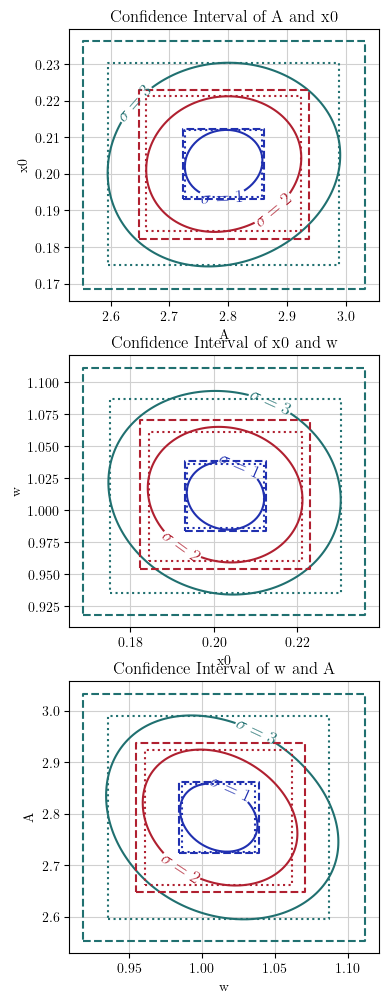

In [52]:
explicitly_calculate_sigma = True
nsamples = 100

aix, aiy = 0, 0
colors = ('#2030b0', '#b02030', '#207070')
sigma_levels = [1,2,3]
fig, axes = plt.subplots(3, 1, figsize=(4, 12))

for pairs in (('A', 'x0'), ('x0', 'w'),
              ('w', 'A')):

    xpar, ypar = pairs
    if explicitly_calculate_sigma:
        print(f"Generating chi-square map for {pairs}")
        c_x, c_y, chi2_mat = conf_interval2d(I_norm_fit_result, I_norm_fit_result, xpar, ypar,
                                             nsamples, nsamples, nsigma=3.5,
                                             chi2_out=True)
        # explicitly calculate sigma matrix: sigma increases chi_square
        # from  chi_square_best
        # to    chi_square + sigma**2 * reduced_chi_square
        # so:   sigma = sqrt((chi2-chi2_best)/ reduced_chi_square)
        chi2_min = chi2_mat.min()
        sigma_mat = np.sqrt((chi2_mat-chi2_min)/I_norm_fit_result.redchi)
    else:
        print(f"Generating sigma map for {pairs}")
        # or, you could just calculate the matrix of probabilities as:
        c_x, c_y, sigma_mat = conf_interval2d(I_norm_fit_result, I_norm_fit_result, xpar, ypar,
                                              nsamples, nsamples, nsigma=3.5)

    # aix += 1
    ax = axes[aiy]
    aiy += 1
    # if aix == 2:
    #     aix = 0
    #     aiy += 1
   

    cnt = ax.contour(c_x, c_y, sigma_mat, levels=sigma_levels, colors=colors,
                     linestyles='-')
    ax.clabel(cnt, inline=True, fmt=r"$\sigma=%.0f$", fontsize=13)

    # draw boxes for estimated uncertaties:
    #  dotted :  scaled stderr from initial fit
    #  dashed :  values found from conf_interval()
    xv = I_norm_fit_result.params[xpar].value
    xs = I_norm_fit_result.params[xpar].stderr
    yv = I_norm_fit_result.params[ypar].value
    ys = I_norm_fit_result.params[ypar].stderr

    cix = ci[xpar]
    ciy = ci[ypar]

    print(cix)
    


    nc = len(sigma_levels)
    for i in sigma_levels:
        # dotted line: scaled stderr
        ax.plot((xv-i*xs, xv+i*xs, xv+i*xs, xv-i*xs, xv-i*xs),
                (yv-i*ys, yv-i*ys, yv+i*ys, yv+i*ys, yv-i*ys),
                linestyle='dotted', color=colors[i-1])

        # dashed line: refined uncertainties from conf_interval
        xsp, xsm = cix[nc+i][1], cix[nc-i][1]
        ysp, ysm = ciy[nc+i][1], ciy[nc-i][1]
        ax.plot((xsm, xsp, xsp, xsm, xsm), (ysm, ysm, ysp, ysp, ysm),
                linestyle='dashed', color=colors[i-1])
    
    ax.set_title(f"Confidence Interval of {xpar} and {ypar}")

    ax.set_xlabel(xpar)
    ax.set_ylabel(ypar)
    ax.grid(True, color='#d0d0d0')
plt.show()